# Boosting

Simple Classifier

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def find_splits(col):
    col=np.sort(np.unique(col))
   
    split_values=np.array((np.array(col[1:]) + np.array(col[:-1]) )/ 2)
    return split_values

$$Entropy_{(\text{node})} = -p_{\text{class1}}*\log_2(p_{\text{class1}}) + -p_{\text{class2}}*\log_2(p_{\text{class2}})$$

In [9]:
def entropy(class1_n, class2_n):
    if (class1_n == 0) or (class2_n == 0):
        return 0
    total = class1_n + class2_n
    class1_proprtion = class1_n/total
    class2_proportion = class2_n/total
    return  sum([-1 * prop * np.log2(prop)
                 for prop in [class1_proprtion, class2_proportion] ])


$$Entropy_{(\text{split})} = p_{\text{node1}} * Entropy_{\text{(node1})}+ p_{\text{node2}}* Entropy_{(\text{node2})},$$  

In [10]:
def node_classes(col, split_value, labels): #provided
        le_node = labels[col <= split_value]
        g_node = labels[col > split_value]

        le_c1 = np.count_nonzero(le_node)
        le_c2 = len(le_node) - le_c1

        g_c1 = np.count_nonzero(g_node)
        g_c2 = len(g_node) - g_c1    
        return le_c1, le_c2, g_c1, g_c2

In [11]:
def ent_from_split(col, split_value, labels):
    A_1,A_0,B_1,B_0=node_classes(col, split_value, labels)
    
    entA = entropy(A_1,A_0)
    entB=entropy(B_1,B_0)
    total = len(col)
    
    pA=(A_1+A_0)/(total)
    pB=(B_1+B_0)/(total)    
    return pA*entA+pB*entB

In [12]:
def pred_from_split(X, y, col_idx, split_value): 
    le_c1,le_c2,g_c1,g_c2=node_classes(X[:,col_idx], split_value, y)
    def pred_for_node(c11,c12):
        if c11>c12: return True
        elif c11<c12: return False
        else: return None
    left = pred_for_node(le_c1,le_c2)
    right = pred_for_node(g_c1,g_c2)
    if ((right==None)or left==None) and (right!=left):
        if left ==None:
            left = not right
        else:
            right = not left
    if (right==None) and (left==None):
        right = True
        left = True

    return (int(left),int(right))

In [13]:
def simple_binary_tree_predict(X, col_idx, split_value, left_pred, right_pred):
    col = X[:,col_idx]
    col=np.where(col<=split_value, left_pred, right_pred)
    return np.array(col)

In [14]:
def simple_binary_tree_fit(X,y): #provided
    best_split = (-1,-1,1)    
    for col_idx, col in enumerate(X.T):
        splits = find_splits(col)
        for s in splits:
            ent = ent_from_split(col, s, y)          
            if ent < best_split[2]:
                best_split = (col_idx, s, ent) 
    left_pred, right_pred = pred_from_split(X, y, *best_split[:2])    
    col_idx, split_value = best_split[:2]    
    return col_idx, split_value, left_pred, right_pred

In [15]:
X = np.array([[0.5, 3. ], [1.,  2. ], [3.,  0.5],
                [2.,  3. ], [3.,  4. ]])
col_idx = 0
split_value = 1.5
left_pred = 1
right_pred = 0

preds = simple_binary_tree_predict(X, col_idx, split_value, left_pred, right_pred)

print(preds)

[1 1 0 0 0]


# Adaptive Boosting Algorithm

In [16]:
def default_weights(n):
    return np.full(n,1/n)

$$\epsilon_t = \sum_{i=1}^nw_t(i)\mathbb{1}\{y_i\ne f_t(x_i)\}$$  

In [17]:
def calc_epsilon(y_true, y_pred, weights):
    summ=0
    for i in range(len(y_true)):
        if y_true[i]!=y_pred[i]:
            summ=summ+weights[i]
    return np.float(summ)

$$\alpha_t = \frac12ln(\frac{1-\epsilon_t}{\epsilon_t})$$  

In [18]:
def calc_alpha(epsilon):
    if epsilon==0:
        return np.inf
    else:
        return 0.5*np.log((1-epsilon)/epsilon)

$$w_{t+1}(i) = \frac{\hat{w}_{t+1}(i)}{\sum_j\hat{w}_{t+1}(j)}$$  


$$\hat{w}_{t+1}(i) = w_t(i)e^{-\alpha_ty_if_t(x_i)}$$

In [19]:
def update_weights(weights, alpha, y_true, y_pred):
    def target_for_weight_update(y):
        toRet=y.copy()
        toRet[toRet==0]=-1
        return toRet
    y=target_for_weight_update(y_true)
    pred=target_for_weight_update(y_pred)
    weights=weights*np.exp(-alpha*y*pred)
    weights=weights/sum(weights)
    return weights

Prediction from boosted trees


$$f_{boost}(x_0) = sign(\sum_{t=1}^T\alpha_tf_t(X_0))$$  

In [20]:
def predict(X, est_dict):
    fin_preds=np.zeros(X.shape[0])
    for k in est_dict:
        preds=est_dict[k][0].predict(X)
        preds[preds<1]=-1
        preds=preds*est_dict[k][1]
        fin_preds +=preds
    fin_preds[fin_preds>=0]=1
    fin_preds[fin_preds<0]=0
    return fin_preds

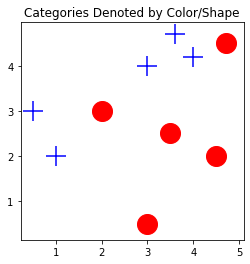

df:
      x    y  classification
0  0.5  3.0               1
1  1.0  2.0               1
2  3.0  0.5              -1
3  2.0  3.0              -1
4  3.0  4.0               1
5  3.5  2.5              -1
6  3.6  4.7               1
7  4.0  4.2               1
8  4.5  2.0              -1
9  4.7  4.5              -1 

threshold: 1.5 feature: 0
threshold: 4.25 feature: 0

tree1 predictions on all elements: [1 1 0 0 0 0 0 0 0 0]
tree2 predictions on all elements: [1 1 1 1 1 1 1 1 0 0]

Entropy of different splits for observations 5-9
Col 1, @ 3.35: 0.5509775004326937
Col 0, # 4.25: 0.5509775004326937


In [21]:
#provided
from sklearn.tree import DecisionTreeClassifier

def simple_tree():
    return DecisionTreeClassifier(criterion = 'entropy', max_depth= 1)

#example
pts = [[.5, 3,1],[1,2,1],[3,.5,-1],[2,3,-1],[3,4,1],
 [3.5,2.5,-1],[3.6,4.7,1],[4,4.2,1],[4.5,2,-1],[4.7,4.5,-1]]

df = pd.DataFrame(pts, columns = ['x','y','classification'])

# Plotting by category

b = df[df.classification ==1]
r = df[df.classification ==-1]
plt.figure(figsize = (4,4))
plt.scatter(b.x, b.y, color = 'b', marker="+", s = 400)
plt.scatter(r.x, r.y, color = 'r', marker = "o", s = 400)
plt.title("Categories Denoted by Color/Shape")
plt.show()


print("df:\n",df, "\n")

### split out X and y
X = df[['x','y']]

# Change from -1 and 1 to 0 and 1
y = np.array([1 if x == 1 else 0 for x in df['classification']])

### Split data in half
X1 = X.iloc[:len(X.index)//2, :]
X2 = X.iloc[len(X.index)//2:, :]

y1 = y[:len(y)//2]
y2 = y[len(X)//2:]


### Fit classifier to both sets of data, save to dictionary:

tree_dict = {}

tree1 = simple_tree()
tree1.fit(X1,y1)
print("threshold:", tree1.tree_.threshold[0], "feature:", tree1.tree_.feature[0])

### made up alpha, for example
alpha1 = .6
tree_dict[1] = (tree1, alpha1)

tree2 = simple_tree()
tree2.fit(X2,y2)
print("threshold:", tree2.tree_.threshold[0], "feature:" ,tree2.tree_.feature[0])

### made up alpha, again.
alpha2 = .35

tree_dict[2] = (tree2, alpha2)

### Create predictions using trees stored in dictionary
print("\ntree1 predictions on all elements:", tree_dict[1][0].predict(X))
print("tree2 predictions on all elements:", tree_dict[2][0].predict(X))

### Showing Ent
print("\nEntropy of different splits for observations 5-9")
print("Col 1, @ 3.35:", ent_from_split(X2.iloc[:,1].values,3.35, y2))
print("Col 0, # 4.25:", ent_from_split(X2.iloc[:,0].values, 4.25, y2))

In [22]:
alpha1 = .6
tree_dict[1] = (tree1, alpha1)

tree2 = simple_tree()
tree2.fit(X2,y2)
print("threshold:", tree2.tree_.threshold[0], "feature:" ,tree2.tree_.feature[0])


alpha2 = .35
tree_dict[2] = (tree2, alpha2)

print(predict(X, tree_dict))

threshold: 4.25 feature: 0
[1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
